# Moment maps of line emission
This is a notebook to project 3D line emission cubes from SIGAME to 2D projections. 

---

### Moment0 map
You can read about moment maps in astronomy here: 

https://www.cfa.harvard.edu/rtdc/CO/MomentMasking/

In [1]:
### Import the modules we will need
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm
from scipy.spatial import cKDTree
import time
fontsize = 15
mpl.rcParams['ytick.labelsize'] = fontsize # increase label size in plots
mpl.rcParams['xtick.labelsize'] = fontsize # increase label size in plots

In [2]:
### First we import the 3D datacube with line emission per cell:
datacube      =    pd.read_pickle('z0.00_G154.cell_data')

In [3]:
### Take a look at the first 5 rows in of the datacube:
datacube.head()

,x,y,z,n_dust,cell_size,cell_volume,rho,m,mH,nH,...,L_[CI]610,L_[CI]370,L_[OI]145,L_[OI]63,L_[OIII]88,L_[NII]122,L_[NII]205,L_CO(3-2),L_CO(2-1),L_CO(1-0)
0,-33.384375,-33.384375,-33.384375,6.842624e-16,4.45125,8.819541e+10,0.000000,0.000000,0.000000,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,-28.933125,-33.384375,-33.384375,6.379016e-14,4.45125,8.819541e+10,0.374555,33.507207,25.130406,1.136257e-08,...,2.456033e-10,2.851155e-10,5.640611e-11,5.544321e-10,3.305449e-04,7.447467e-07,1.278644e-06,3.790162e-154,2.583049e-154,9.398867e-155
2,-33.384375,-28.933125,-33.384375,2.575094e-14,4.45125,8.819541e+10,0.100339,8.976203,6.732153,3.043904e-09,...,1.525172e-10,1.792077e-10,3.595951e-11,3.607771e-10,7.106423e-05,2.951656e-07,5.033596e-07,6.652050e-136,4.527179e-136,1.647774e-136
3,-28.933125,-28.933125,-33.384375,4.109049e-13,4.45125,8.819541e+10,7.383429,660.511777,495.383833,2.239849e-07,...,4.674814e-09,5.431582e-09,1.067432e-09,1.049962e-08,6.166658e-03,1.418166e-05,2.411644e-05,2.091446e-152,1.424733e-152,5.183302e-153
4,-33.384375,-33.384375,-28.933125,3.234949e-16,4.45125,8.819541e+10,0.000021,0.001909,0.001431,6.472358e-13,...,1.183970e-15,1.450916e-15,8.222523e-17,8.381585e-16,1.840583e-10,1.740007e-12,1.891014e-12,1.786924e-97,1.542492e-97,9.875854e-98


In [4]:
### Count number of cells
N_models = len(datacube)
print('%i cells found' % N_models)

662684 cells found


In [5]:
datacube.keys()

Index(['x', 'y', 'z', 'n_dust', 'cell_size', 'cell_volume', 'rho', 'm', 'mH',
       'nH', 'F_FUV_W_m2', 'F_FUV_Habing', 'E_FUV_ergs_cm3', 'G0',
       'SFR_density', 'Z', 'Mach', 'cell_size_lookup', 'mf_1e3', 'mf_1e1',
       'L_[CII]158', 'L_[CI]610', 'L_[CI]370', 'L_[OI]145', 'L_[OI]63',
       'L_[OIII]88', 'L_[NII]122', 'L_[NII]205', 'L_CO(3-2)', 'L_CO(2-1)',
       'L_CO(1-0)'],
      dtype='object')

### Here's an explanation of what the relevant columns mean:
x,y,z       : center coordinates of each cell \
cell_size   : cell size in kpc \
cell_volume : cell volume in pc^3 

In addition there are the line luminosities named L_\[CI\]610, L_\[CI\]370, L_\[CII\]158 etc. All of these are in solar luminosities.

If you look at the cell sizes, you'll see that they are grouped in "levels" determined by the radiative transfer code to give the best convergence. The smallest cells can actually be very luminous because they tend to contain denser gas which emits more.

In [6]:
#data:

dataset = np.column_stack([datacube.x, datacube.y, datacube.z, datacube.cell_size, datacube['L_[CI]610']])
#First three columns of dataset are x,y,z coordinates. Fourth column is cell-sizes. Last column is CI-610 luminosity here.
#If you want any other luminosity projected rather than this one, then change the last column accordingly.

coordinates = dataset[:,0:3]                         #(An array containing just x,y,z coordinates as columns respectively)
cellsize = dataset[:,3]       #kpc                   #(Cell-sizes in kpc)
luminosity = dataset[:,4]     #solar_luminosity      #(Aforementioned luminosity in solar luminosity)
X = dataset[:, 0]                                    #(x-coordinates)
Y = dataset[:, 1]                                    #(y-coordinates)
Z = dataset[:, 2]                                    #(z-coordinates)

In [7]:
#minimum and maximum coordinates:

xmin, xmax = min(X), max(X)
ymin, ymax = min(Y), max(Y)
zmin, zmax = min(Z), max(Z)
xminindex, xmaxindex = np.where(X == xmin)[0][0], np.where(X == xmax)[0][0]
yminindex, ymaxindex = np.where(Y == ymin)[0][0], np.where(Y == ymax)[0][0]
zminindex, zmaxindex = np.where(Z == zmin)[0][0], np.where(Z == zmax)[0][0]
xmin, xmax, ymin, ymax, zmin, zmax

(-33.384375, 35.33179688, -34.4971875, 34.4971875, -34.4971875, 34.4971875)

In [8]:
#luminosity_density in cell:
cellvolume = cellsize * cellsize * cellsize  #kpc^3
celldensity =  luminosity / cellvolume           #solar_luminosity / kpc^3

In [9]:
#cell setups: 

cellstartx = X - (cellsize / 2)
cellstarty = Y - (cellsize / 2)
cellstartz = Z - (cellsize / 2)
cellendx = cellstartx + cellsize
cellendy = cellstarty + cellsize
cellendz = cellstartz + cellsize

#Arrays containing index and x,y,z-coordinate details of each cell:
cellx = np.column_stack([datacube.index, cellstartx, cellendx])
celly = np.column_stack([datacube.index, cellstarty, cellendy])
cellz = np.column_stack([datacube.index, cellstartz, cellendz]) 

Let's start by setting a pixel volume of 1 kpc^3. You could start by having the sightline go in the x-direction for instance.

In [10]:
#size of the pixel-cube:
PIXELSIZE = 1 #kpc in 1D

### KD-Tree:

The tool used is scipy's KD-Tree function which finds all k nearest neighbors to each point that you are interested in:

https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.html

(If we want perfect precision then we should put k to be: maxknn = int(PIXELSIZE / min(cellvolume). This number tells us the maximum number of cells that can overlap with a pixel, so finding all of these nearest neighbour would assure precision, however it increses the processing time exponentially, thus I would not recommend this unless you have excess to high-processing power.)

In [11]:
tree = cKDTree(np.c_[X.ravel(), Y.ravel(), Z.ravel()])
maxknn = int(PIXELSIZE/min(cellvolume)) + 1

### Algorithm:

1. We will first apply KD-Tree to centre-coordinates of the pixel. (k=100 finds only 100 nearest neighbours here)
2. Loop through these k nearest neighbours of the given pixel.
3. In the loop, to find overlapping cells, we use the if statement stated in the code.
   If statement: in 1 direction (let's say x), min from the ending edge of the cell or pixel is subtracted from the max of the
   startinging edge of the cell or pixel. If this substraction is lesser than 0 then the cell and pixel is overlapping.
4. In the if statement, now that the overlapping is assured, we find the edge lengths of the overlapping cuboid.
   This is being done by subtracting coordinates of max from the starting edge of the cell or pixel from the min of the ending
   edge of the cell or pixel. 
5. Now we find the volume of the overlapping cuboid and multiply it with the luminosity-density of the cell.
6. By repeating the loop through every cell, we add up all the luminosity due to overlap. 

In [12]:
#finding the total luminosity of a single pixel:

def pixel_luminosity(X, Y, Z, tree, cellx, celly, cellz, pixel, celldensity, maxknn):
    '''
    This function returns the total luminosity of the pixel using the algorithm shown above.
    '''
    
    #pixel-coordinates:
    pixelstartx = pixel[0]
    pixelendx = pixel[1]
    pixelstarty = pixel[2]
    pixelendy = pixel[3]
    pixelstartz = pixel[4]
    pixelendz = pixel[5]
    
    pixelcentrex = pixelstartx + (PIXELSIZE / 2)
    pixelcentrey = pixelstarty + (PIXELSIZE / 2)
    pixelcentrez = pixelstartz + (PIXELSIZE / 2)
    
    #1. Query method of KD-Tree:
    dd, ii = tree.query([[pixelcentrex, pixelcentrey, pixelcentrez]], k=maxknn)
    
    #Appending coordinate values of nearest cells gained by KD-Tree:
    x = []
    y = []
    z = []
    for index in ii[0]:
        x.append(cellx[index])
        y.append(celly[index])
        z.append(cellz[index])
        
    #2. For loop to go over each cell:
    pixelluminosity = 0
    for i in range(len(x)):
        
        #3. if statement to find whether the cell overlaps the pixel or not:
        if (max(pixelstartx, x[i][1]) - min(pixelendx, x[i][2]) < 0) and (max(pixelstarty, y[i][1]) - min(pixelendy, y[i][2]) < 0) and (max(pixelstartz, z[i][1]) - min(pixelendz, z[i][2]) < 0):
            
            #4. Finding edge lengths of overlapping cuboid:
            edgex = min(pixelendx, x[i][2])-max(pixelstartx,x[i][1])
            edgey = min(pixelendy, y[i][2])-max(pixelstarty,y[i][1])
            edgez = min(pixelendz, z[i][2])-max(pixelstartz,z[i][1])
        
            #5. Finding overlapping volume and luminosity due to that overlpping cell:
            crossvolume = edgex * edgey * edgez
            luminosity = celldensity[int(x[i][0])] * crossvolume
            
            #6. Adding up the luminosity due to each cell:
            pixelluminosity += luminosity
    
    return pixelluminosity

Now we run three while loops inside each other to sum up luminosity of every pixel in a line of sight. Here, we are adding up the luminosities in x-direction. Thus, our projection would be in yz-plane. 

In [13]:
#while loops:

start = time.time()

#While loop to go through z-direction:
index = 0
momentmapdata = []
pixelstartz = zmin - (cellsize[zminindex] / 2)
while pixelstartz <= zmax - (cellsize[zmaxindex] / 2): 
    pixelendz = pixelstartz + PIXELSIZE
    
    #While loop to go through y-direction:
    pixelstarty = ymin - (cellsize[yminindex] / 2)
    while pixelstarty <= ymax + (cellsize[ymaxindex] / 2):
        pixelendy = pixelstarty + PIXELSIZE
        
        #While loop to go through x-direction:
        lineluminosity = 0
        pixelstartx = xmin - (cellsize[xminindex] / 2)
        while pixelstartx <= xmax + (cellsize[xmaxindex] / 2):
            pixelendx = pixelstartx + PIXELSIZE
            
            #Pixel coordinates:
            pixel = [pixelstartx, pixelendx, pixelstarty, pixelendy, pixelstartz, pixelendz]
            
            #Calling pixel_luminosity function for the particular pixel: 
            pixelluminosity = pixel_luminosity(X, Y, Z, tree, cellx, celly, cellz, pixel, celldensity, maxknn)
            
            #Adding up luminosities of pixels in the line of sight:
            lineluminosity += pixelluminosity
            
            pixelstartx += PIXELSIZE
        
        #central yz-coordinates of each pixel-lines:
        pixel_y = pixelstarty + (PIXELSIZE/2)
        pixel_z = pixelstartz + (PIXELSIZE/2)
        
        #Appending data of each pixelline for 2D projection:
        momentmapdata.append([int(index), pixel_y, pixel_z, lineluminosity])
        
        index += 1
        pixelstarty += PIXELSIZE
    
    pixelstartz += PIXELSIZE
    
end = time.time()

In [14]:
#Time taken to run the loops: 
print('Time:', round(float(end-start), 4), 'seconds')

Time: 4908.2256 seconds


In [15]:
#Data for momentmap:
momentmap = np.array(momentmapdata)
momentmap

array([[ 0.00000000e+00, -3.51100000e+01, -3.51100000e+01,
         2.20247926e-09],
       [ 1.00000000e+00, -3.41100000e+01, -3.51100000e+01,
         2.20247926e-09],
       [ 2.00000000e+00, -3.31100000e+01, -3.51100000e+01,
         2.20247926e-09],
       ...,
       [ 4.96500000e+03,  3.38900000e+01,  3.28900000e+01,
         7.51155999e-10],
       [ 4.96600000e+03,  3.48900000e+01,  3.28900000e+01,
         7.51155999e-10],
       [ 4.96700000e+03,  3.58900000e+01,  3.28900000e+01,
         1.65254320e-10]])

In [16]:
momentmap.shape

(4968, 4)

### Momentmap Data:

Fisrt column of the array is index. Second and third colums are y and z coordinates, respectively. The last column is the added up luminosity in solar luminosity. 

### Plots:

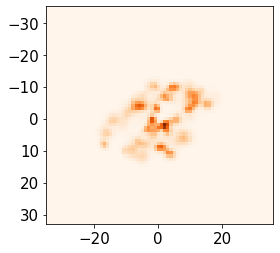

In [22]:
#Deviding y-z coordinates in 72x69 (yxz) pixel: 
y,z,lum = momentmap[:, 1], momentmap[:, 2], momentmap[:, 3]
nrows, ncols = 69, 72
grid = lum.reshape((nrows, ncols))

plt.imshow(grid, extent=(y.min(), y.max(), z.max(), z.min()),
           interpolation='nearest', cmap=cm.Oranges)
plt.show()

In [23]:
max(lum)

16393.245453841108

In [24]:
add = 0
for x in lum:
    add += x
add

1848660.2435299403

In [25]:
summ = 0 
for x in luminosity:
    summ += x
summ

1850304.4692148971